In [2]:
import sys,os
sys.path.append('/home/sandbox/Git_projects/devito/examples/seismic/')
sys.path.append('/home/bl8/Git_projects/devito/examples/seismic/')
from model import Model
from plotting import plot_velocity
from source import RickerSource
from devito import TimeFunction
from devito import Eq
from sympy import solve
from devito import Operator

In [3]:
try:
    import sys,os
    sys.path.append('/home/sandbox/Git_projects/devito/examples/seismic/')
    sys.path.append('/home/bl8/Git_projects/devito/examples/seismic/')
    from model import Model
    from plotting import plot_velocity
    from source import RickerSource
    from devito import TimeFunction
    from devito import Eq
    from sympy import solve
    from devito import Operator
    print("Import succesfull")
except ImportError:
    print('Devito is not working')
finally:
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy as sp
    import scipy.ndimage
    from matplotlib import cm

def scale_linear(data, high, low):
    mins = np.amin(data)
    maxs = np.amax(data)
    rng = maxs - mins
    return high - (((high - low) * (maxs - data)) / rng)

def smooth_topo(data, sigma_x=2, sigma_y=2):
    sigma = [sigma_y, sigma_x]
    dataSmooth = sp.ndimage.filters.gaussian_filter(data, sigma, mode='nearest')
    return dataSmooth

def simulate_seismic_topo (topo, circles_list, not_circles, 
                           vmax=5, vmin=1, f0 = 0.02500, dx=10, dy=10, t0=0, tn=700, 
                           pmlthickness=40, sigma_x=2, sigma_y=2, n_frames = 50):
    if circles_list == []:
        circles_list = [[int(topo.shape[0]/2),int(topo.shape[1]/2)]]
    circles = np.array(circles_list)

    topo = topo.astype(np.float32)
    topoRescale = scale_linear(topo, vmax, vmin)
    veltopo=smooth_topo( topoRescale, sigma_x, sigma_y )
    if not_circles != []:
        veltopo[not_circles] = vmax * 1.8

    # Define the model
    model = Model(origin=(0, 0), # Top left corner.
               spacing=(dx, dy),  # Grid spacing in m.
              shape=veltopo.shape,    # Number of grid points.
              space_order=1,
              vp=veltopo,        # A velocity model.
              nbl=pmlthickness)          # boundary layer.

    dt = model.critical_dt  # Time step from model grid spacing
    nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
    time = np.linspace(t0, tn, nt)  # Discrete modelling time

    u = TimeFunction(name="u", grid=model.grid,
                 time_order=2, space_order=2,
                 save=True, time_dim=nt)
    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = Eq(u.forward, solve(pde, u.forward)[0])


    src_coords = np.multiply(circles[0],[dx,dy])
    src = RickerSource(name='src0', grid=model.grid, f0=f0, time=time, coordinates=src_coords)
    src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)

    if circles.shape[0]>1:
        for idx, row in enumerate(circles[1:,:]):
            namesrc = 'src' + str(idx+1)
            src_coords = np.multiply(row,[dx,dy])
            src_temp = RickerSource(name=namesrc, grid=model.grid, f0=f0, time=time, coordinates=src_coords)
            src_term_temp = src_temp.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)
            src_term += src_term_temp

    op_fwd = Operator( [stencil] + src_term )
    op_fwd(time=nt, dt=model.critical_dt)

    wf_data = u.data[:,pmlthickness:-pmlthickness,pmlthickness:-pmlthickness]
    wf_data_normalize = wf_data/np.amax(wf_data)

    framerate=np.int(np.ceil(wf_data.shape[0]/n_frames))
    return wf_data_normalize[0::framerate,:,:]

def overlay_seismic_topography(image_in, wavefield_cube, time_slice, mask_flag = 0, thrshld = .01, outfile=None):

    topo_image = plt.imread(image_in)

    if topo_image.shape[:2] != wavefield_cube.shape[1:]:
        wavefield = np.transpose(wavefield_cube[time_slice,:,:])
        if topo_image.shape[:2] != wavefield.shape:
            print("Topography shape does not match the wavefield shape")
    else:
        wavefield = wavefield_cube[time_slice,:,:]

    fig = plt.figure(figsize=(topo_image.shape[1]/100,topo_image.shape[0]/100), dpi=100, frameon=False)
#    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    data_param = dict(vmin=-.1e0, vmax=.1e0, cmap=cm.seismic, aspect=1, interpolation='none')

    if mask_flag == 0:
        waves = wavefield
        ax = plt.imshow(topo_image)
        ax = plt.imshow(waves, alpha=.4, **data_param)
    else:
        waves = np.ma.masked_where(np.abs(wavefield) <= thrshld , wavefield)
        ax = plt.imshow(topo_image)
        ax = plt.imshow(waves, **data_param)


    if outfile==None:
            plt.show()
            plt.close()
    else:
        plt.savefig(outfile, pad_inches=0)
        plt.close(fig)

Import succesfull


In [4]:
from sandbox import _test_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

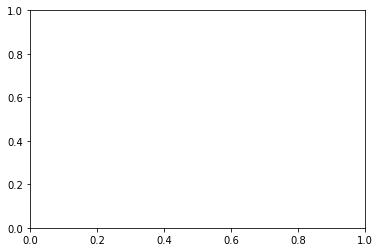

In [5]:
file = np.load(_test_data['topo'] + "DEM1.npz")
frame = file['arr_0']
extent = [0, frame.shape[1], 0, frame.shape[0], frame.min(), frame.max()]

fig, ax = plt.subplots()
sb_params = {'frame': frame,
            'ax': ax,
            'fig': fig,
            'extent': extent,
            'marker': [],
            'cmap': plt.cm.get_cmap('viridis'),
            'norm': None,
            'active_cmap': True,
            'active_contours': True}

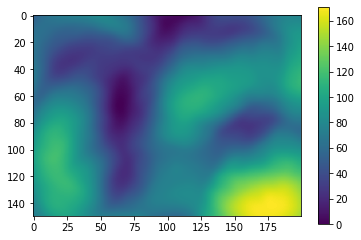

In [6]:
frame_nor = frame - frame.min()
plt.imshow(frame_nor)
plt.colorbar()

In [7]:

#
topo=frame_nor 
#topo=vp
circles_list = [] 
not_circles =[]
vmax=5 
vmin=1
f0 = 0.02500
dx=10
dy=10
t0=0
tn=1000
pmlthickness=40
sigma_x=2
sigma_y=2
n_frames = 50
space_order=3

In [8]:
if circles_list == []:
    circles_list = [[int(topo.shape[0]/2),int(topo.shape[1]/2)]]
circles = np.array(circles_list)

topo = topo.astype(np.float32)
topoRescale = scale_linear(topo, vmax, vmin)
veltopo=smooth_topo( topoRescale, sigma_x, sigma_y )
if not_circles != []:
    veltopo[not_circles] = vmax * 1.8

In [9]:
vp = np.empty((101, 101), dtype=np.float32)
vp[:, :51] = 1.5
vp[:, 51:] = 2.5
model1 = Model(vp=vp,             # A velocity model.
              origin=(0, 0),     # Top left corner.
              shape=(101, 101),  # Number of grid points.
              spacing=(10, 10),  # Grid spacing in m.
              nbpml=40,
              space_order=space_order
             )          # boundary layer.

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


In [7]:
model = Model(vp=veltopo,        # A velocity model.
                  origin=(0, 0),     # Top left corner.
                  shape=veltopo.shape,    # Number of grid points.
                  spacing=(dx, dy),  # Grid spacing in m.
              space_order=space_order,    
              nbpml=pmlthickness)          # boundary layer.

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


In [8]:
dt = model.critical_dt  # Time step from model grid spacing
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

In [9]:
nt

868

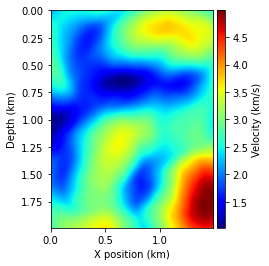

In [10]:
plot_velocity(model)

In [ ]:
model.grid.time_dim

In [11]:
u = TimeFunction(name="u", grid=model.grid,
             time_order=2, space_order=space_order,)
             #save=True, time_dim=nt)

In [12]:
model.m

vp(x, y)**(-2)

In [13]:
u.dt2

Derivative(u(t, x, y), (t, 2))

In [14]:
u.laplace

Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2))

In [15]:
model.damp

damp(x, y)

In [16]:
u.dt

Derivative(u(t, x, y), t)

In [24]:
pde = Tuple(model.m * u.dt2 - u.laplace + model.damp * u.dt)

In [25]:
pde

(damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2,)

In [ ]:
u.forward

In [ ]:
pde.

In [30]:
solve(pde, u.backward, implicit=True)#, set=True)

TypeError: 'tuple' object is not callable

In [23]:
from sympy import solve, Poly, Eq, Function, exp, Tuple
from sympy.abc import x, y, z, a, b

f = Function('f')
solve(x < 3)

(-oo < x) & (x < 3)

In [20]:
solve([x**2 - 3, y - 1], set=True)

([x, y], {(-sqrt(3), 1), (sqrt(3), 1)})

In [ ]:
stencil = Eq(u.forward, solve(pde, u.forward)[0])

In [ ]:
src_coords = np.multiply(circles[0],[dx,dy])
src = RickerSource(name='src0', grid=model.grid, f0=f0, time=time, coordinates=src_coords)
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)

if circles.shape[0]>1:
    for idx, row in enumerate(circles[1:,:]):
        namesrc = 'src' + str(idx+1)
        src_coords = np.multiply(row,[dx,dy])
        src_temp = RickerSource(name=namesrc, grid=model.grid, f0=f0, time=time, coordinates=src_coords)
        src_term_temp = src_temp.inject(field=u.forward, expr=src * dt**2 / model.m, offset=model.nbpml)
        src_term += src_term_temp

op_fwd = Operator( [stencil] + src_term )
op_fwd(time=nt, dt=model.critical_dt)

wf_data = u.data[:,pmlthickness:-pmlthickness,pmlthickness:-pmlthickness]
wf_data_normalize = wf_data/np.amax(wf_data)

framerate=np.int(np.ceil(wf_data.shape[0]/n_frames))

In [ ]:
model = Model(origin=(0, 0), # Top left corner.
               spacing=(dx, dy),  # Grid spacing in m.
              shape=veltopo.shape,    # Number of grid points.
              space_order=1
              vp=veltopo,        # A velocity model.
              nbl=pmlthickness)          # boundary layer.

In [ ]:
Model()